In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import shap
from lime import lime_image
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution
from PIL import Image
from skimage.segmentation import mark_boundaries
import os
import cv2

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
class BrainTumorCNN(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), nn.Dropout(dropout_p),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), nn.Dropout(dropout_p),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), nn.Dropout(dropout_p)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512), nn.ReLU(), nn.Dropout(dropout_p),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [69]:
class EnsembleModel(torch.nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = models

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.stack(outputs).mean(dim=0)

In [70]:
def load_ensemble_model(paths):
    models_list = []
    for path in paths:
        model = BrainTumorCNN().to(device)
        state_dict = torch.load(path, map_location=device)
        model.load_state_dict(state_dict)
        model.eval()
        models_list.append(model)
    return EnsembleModel(models_list).to(device)

In [71]:
model_paths = ["../models/ensemble/ensemble_model_0.pth", 
               "../models/ensemble/ensemble_model_1.pth", 
               "../models/ensemble/ensemble_model_2.pth"]
model = load_ensemble_model(model_paths)
model.eval()

EnsembleModel()

In [72]:
base_model = model.models[0]   # Grad-CAM & IG, pick one submodel

In [73]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder("../data/Testing", transform=transform)
class_names = dataset.classes
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)
images, labels = next(iter(loader))
image, label = images[0].unsqueeze(0).to(device), labels[0].item()
background = images[1:5].to(device)

# batch_images, batch_labels = next(iter(loader))
# image = batch_images[0].unsqueeze(0).to(device)          # (1, 3, 224, 224)
# background_batch = batch_images[1:5].to(device)          # (4, 3, 224, 224)
# label = batch_labels[0].item()

In [74]:
# Helper: Convert tensor to image
def tensor_to_image(tensor):
    image = tensor.squeeze().detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())
    return image

In [75]:
# Grad-CAM
def gradcam(image):
    layer_gc = LayerGradCam(base_model, base_model.features[-4])  # last conv layer
    attributions_gc = layer_gc.attribute(image, target=label)
    upsampled_gc = LayerAttribution.interpolate(attributions_gc, (224, 224)).squeeze().cpu().detach().numpy()
    return upsampled_gc

# Integrated Gradients
def integrated_gradients(image):
    baseline = torch.zeros_like(image)
    ig = IntegratedGradients(base_model)
    attr = ig.attribute(image, baseline, target=label)
    return attr.squeeze().cpu().detach().numpy().mean(axis=0)

# SHAP
def shap_explanation(image, background):
    """
    Generate a SHAP explanation heatmap for a given image.

    Args:
        image (torch.Tensor): shape (1, 3, 224, 224)
        background (torch.Tensor): shape (N, 3, 224, 224)

    Returns:
        np.ndarray: normalized SHAP heatmap (H, W)
    """
    explainer = shap.GradientExplainer(base_model, background)
    shap_values = explainer.shap_values(image)

    # Reduce across channels if needed
    shap_image = shap_values[0][0]
    if shap_image.ndim == 3 and shap_image.shape[0] == 3:
        shap_image = shap_image.mean(axis=0)

    # Safe normalization
    min_val, max_val = shap_image.min(), shap_image.max()
    if max_val - min_val < 1e-6:
        shap_image_normalized = np.zeros_like(shap_image)
    else:
        shap_image_normalized = (shap_image - min_val) / (max_val - min_val)

    return shap_image_normalized


# LIME
def lime_explanation(image_tensor):
    def batch_predict(images_np):
        images_tensor = torch.tensor(images_np).permute(0, 3, 1, 2).float().to(device)
        with torch.no_grad():
            probs = torch.softmax(model(images_tensor), dim=1)
        return probs.cpu().numpy()

    img = tensor_to_image(image_tensor)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img, batch_predict, top_labels=1, hide_color=0, num_samples=1000)

    # Get top predicted label from LIME's explanation
    predicted_label = explanation.top_labels[0]

    img, mask = explanation.get_image_and_mask(
        predicted_label, positive_only=True, hide_rest=False)
    return mark_boundaries(img, mask)

In [76]:
# Display Comparisons
def show_comparisons():
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(tensor_to_image(image))
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(gradcam(image), cmap='hot')
    axs[1].set_title("Grad-CAM")
    axs[1].axis('off')

    axs[2].imshow(integrated_gradients(image), cmap='hot')
    axs[2].set_title("Integrated Gradients")
    axs[2].axis('off')

    axs[4].imshow(lime_explanation(image))
    axs[4].set_title("LIME")
    axs[4].axis('off')

    axs[3].imshow(shap_explanation(image, background), cmap='hot')
    axs[3].set_title("SHAP")
    axs[3].axis('off')


    plt.tight_layout()
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

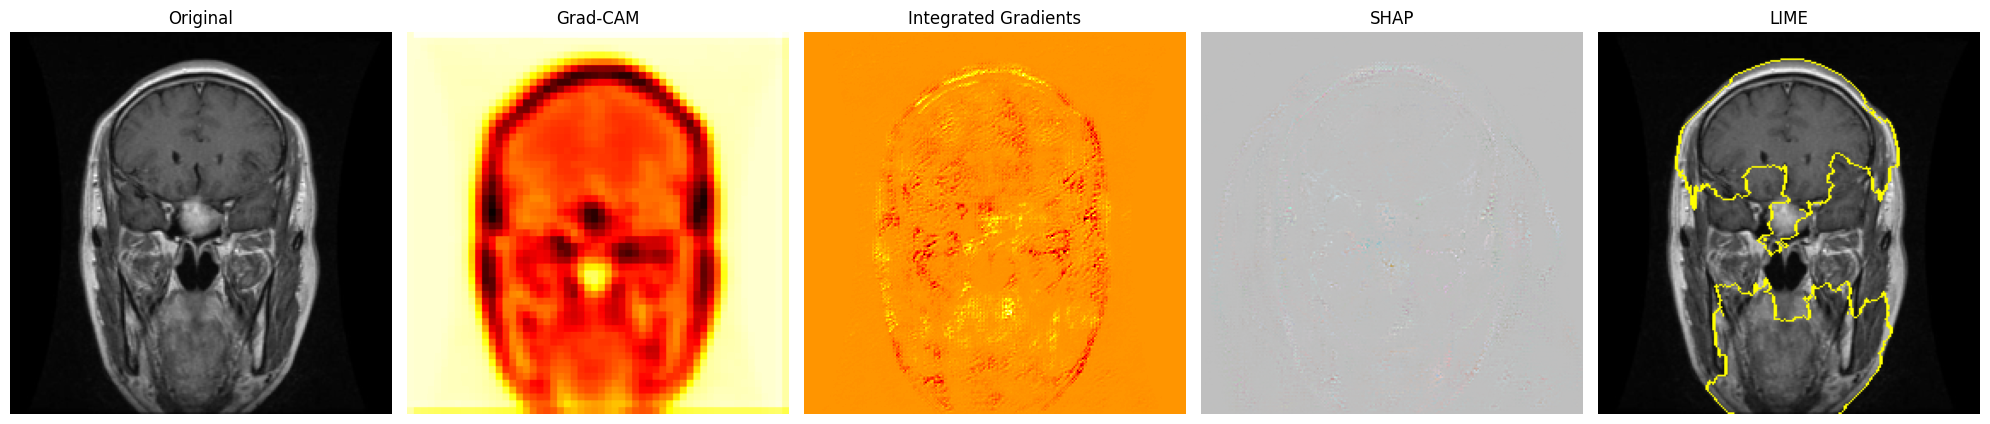

In [77]:
show_comparisons()

## Show comparison on batch

In [79]:
def show_comparisons_on_batch(model, base_model, dataset, class_names, sample_count=10):
    loader = torch.utils.data.DataLoader(dataset, batch_size=sample_count + 5, shuffle=True)
    batch_images, batch_labels = next(iter(loader))

    fig, axs = plt.subplots(sample_count, 5, figsize=(20, 4 * sample_count))

    for i in range(sample_count):
        image = batch_images[i].unsqueeze(0).to(device)
        label = batch_labels[i].item()
        background = batch_images[sample_count:sample_count+4].to(device)  # 4-image background
        class_label = class_names[label]

        axs[i][0].imshow(tensor_to_image(image))
        axs[i][0].set_title(f"Original\n{class_label}")
        axs[i][0].axis('off')

        axs[i][1].imshow(gradcam(image), cmap='hot')
        axs[i][1].set_title("Grad-CAM")
        axs[i][1].axis('off')

        axs[i][2].imshow(integrated_gradients(image), cmap='hot')
        axs[i][2].set_title("Integrated Gradients")
        axs[i][2].axis('off')

        axs[i][3].imshow(shap_explanation(image, background), cmap='hot')
        axs[i][3].set_title("SHAP")
        axs[i][3].axis('off')

        axs[i][4].imshow(lime_explanation(image))
        axs[i][4].set_title("LIME")
        axs[i][4].axis('off')

    plt.tight_layout()
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

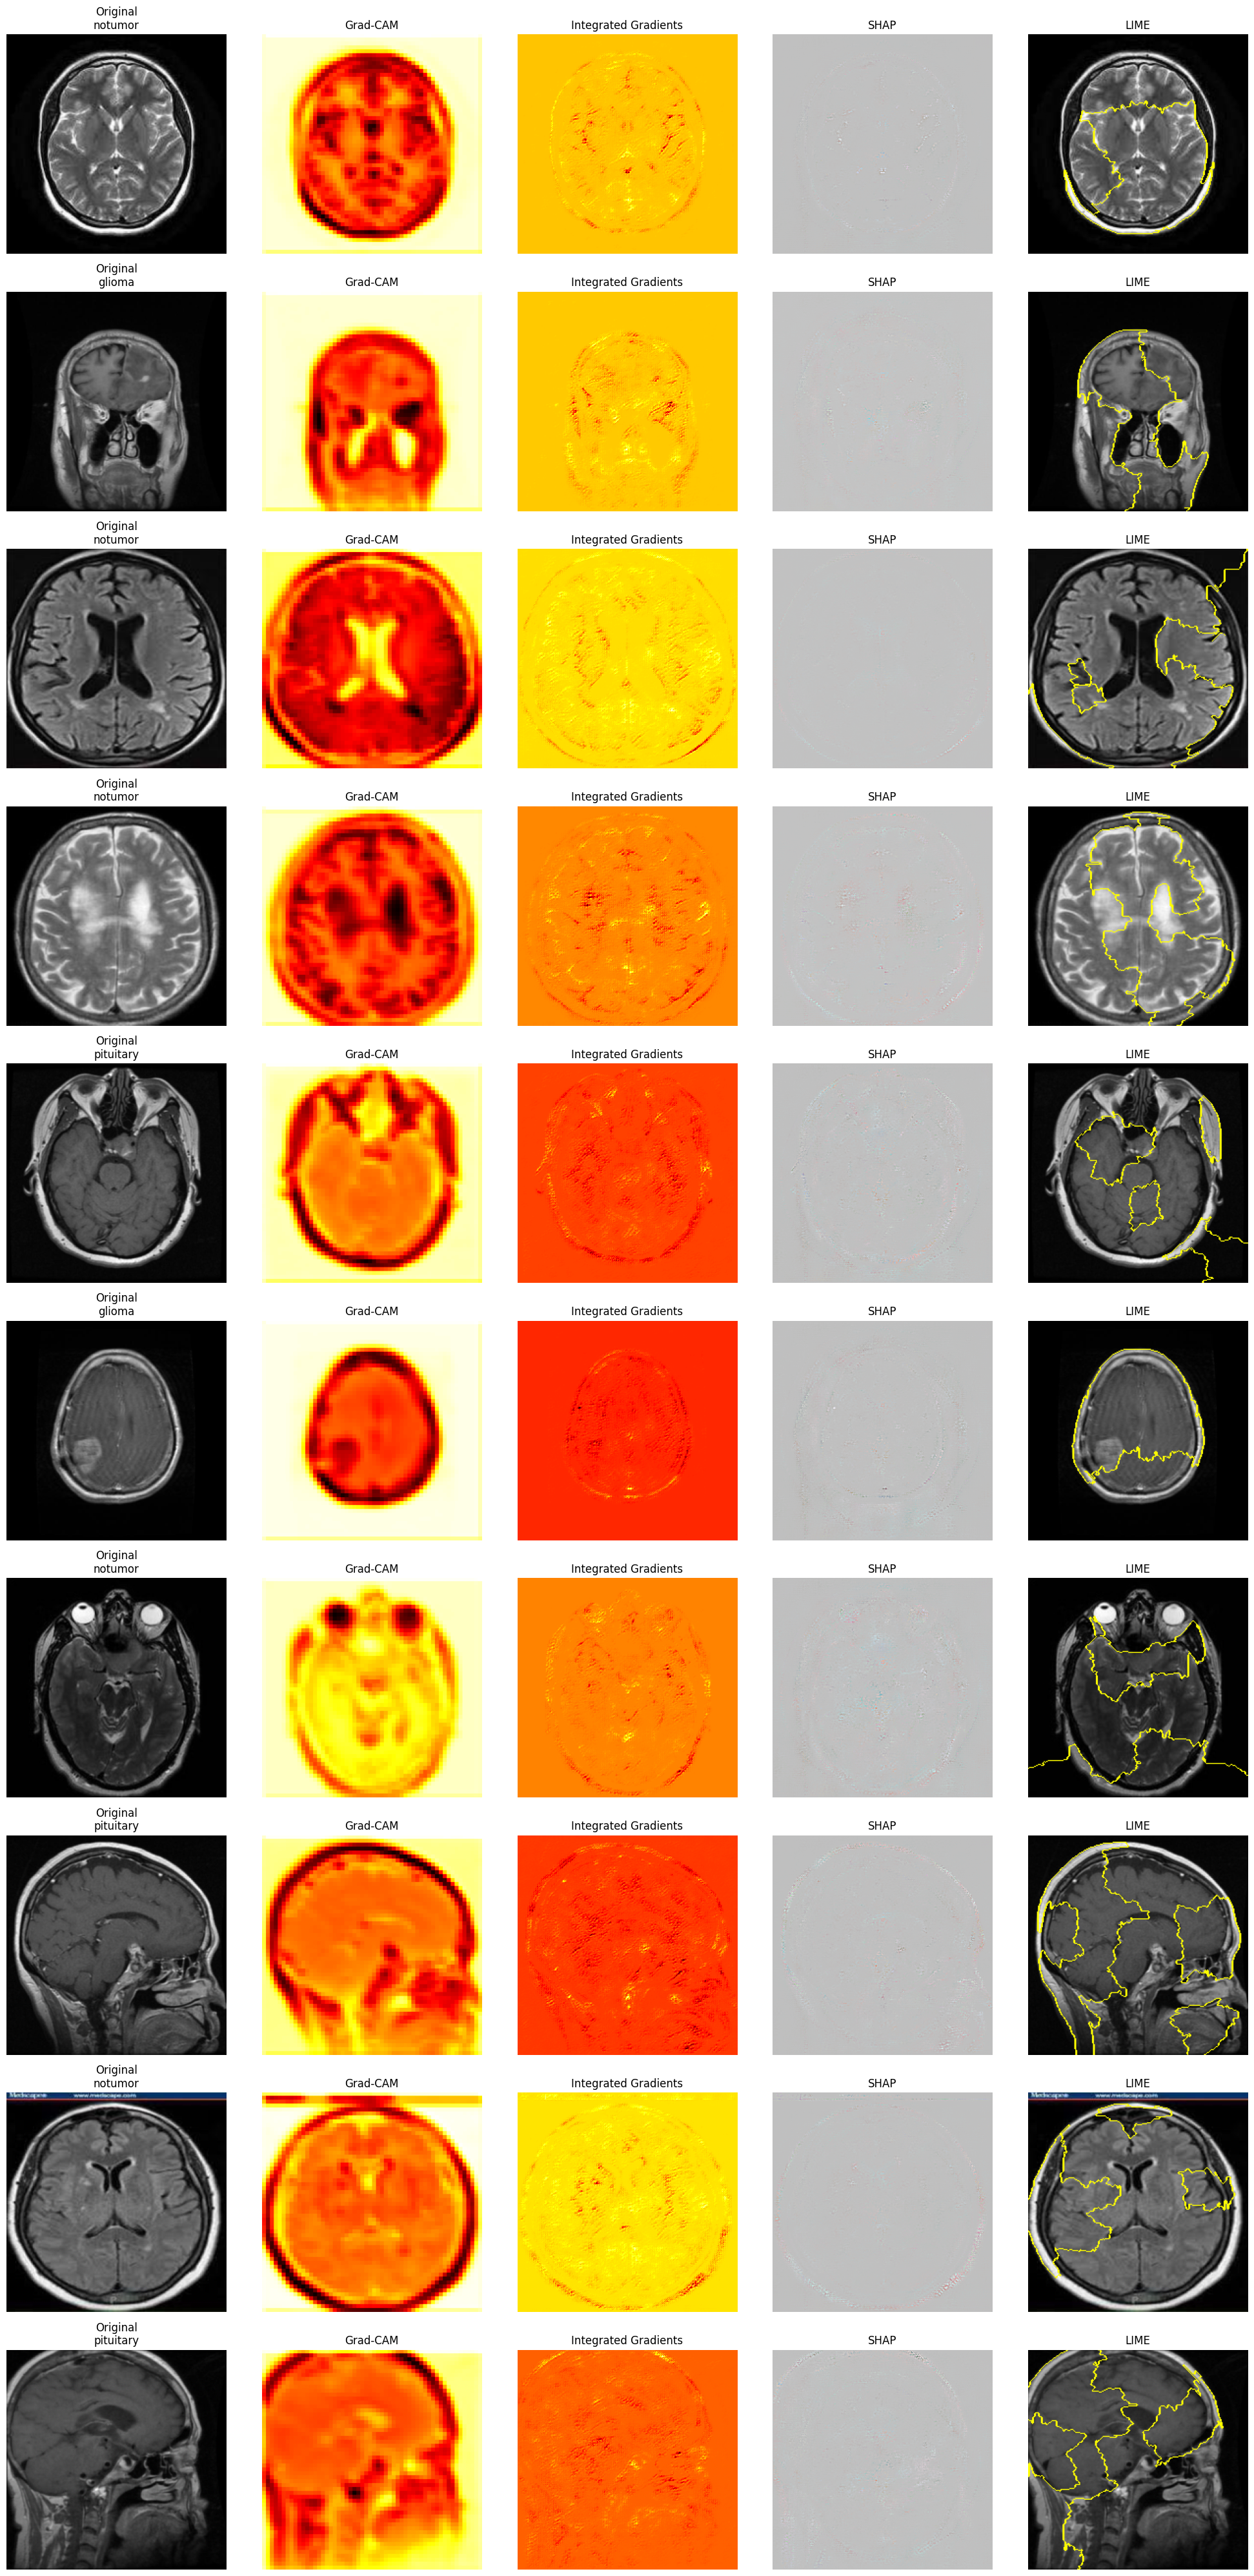

In [80]:
show_comparisons_on_batch(model, base_model, dataset, class_names, sample_count=10)

## Check shap

In [34]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder("../data/Testing", transform=transform)
class_names = dataset.classes
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

# Load 5 images: 1 for explanation, 4 for SHAP background
batch_images, batch_labels = next(iter(loader))
image = batch_images[0].unsqueeze(0).to(device)          # (1, 3, 224, 224)
background_batch = batch_images[1:5].to(device)          # (4, 3, 224, 224)
label = batch_labels[0].item()

In [65]:
print("image_tensor shape:", image.shape)
print("images_batch shape:", background.shape)

image_tensor shape: torch.Size([1, 3, 224, 224])
images_batch shape: torch.Size([0, 3, 224, 224])


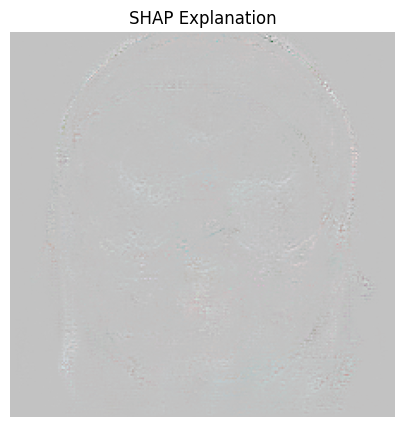

In [38]:
import shap
import matplotlib.pyplot as plt
import numpy as np

def shap_explanation_only(image_tensor, base_model, background_batch):
    """
    Generate and display SHAP explanation for a single image using GradientExplainer.
    
    Args:
        image_tensor (torch.Tensor): shape (1, 3, 224, 224)
        base_model (nn.Module): a single model from your ensemble
        background_batch (torch.Tensor): shape (N, 3, 224, 224)
    """
    import shap
    import matplotlib.pyplot as plt
    import numpy as np

    # 🔍 SHAP GradientExplainer
    explainer = shap.GradientExplainer(base_model, background_batch)
    shap_values = explainer.shap_values(image_tensor)

    # 🧠 Get (3, H, W) and reduce across channels
    shap_map = shap_values[0][0]
    if shap_map.ndim == 3 and shap_map.shape[0] == 3:
        shap_map = shap_map.mean(axis=0)

    # ⚠ Normalize safely
    min_val, max_val = shap_map.min(), shap_map.max()
    if max_val - min_val < 1e-6:
        shap_map_norm = np.zeros_like(shap_map)
    else:
        shap_map_norm = (shap_map - min_val) / (max_val - min_val)

    # 📊 Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(shap_map_norm, cmap='hot')
    plt.title("SHAP Explanation")
    plt.axis('off')
    plt.show()


# ✅ Usage
shap_explanation_only(image, base_model, background_batch)